# Goal 

In this blog post, we implement simple gradient descent, stochastic gradient descent, and a momentum method to enhance the stochastic gradient descent. These are all helpful algorithms to optimize convex functions given that finding any local minimizer is equivalent to finding the global minimizer for these kind of functions. Then, we compare the performance of these three algorithms for training logistic regression. 

In [245]:
%reload_ext autoreload 
%autoreload 2

import numpy as np

def fit(self, X ,y, alpha=0.01, max_epochs=100):
        """
        Fits weights to data using standard gradient descent. 
        """
        X_ = self.pad(X)
        self.w = .5 - np.random.rand(X.shape[1] + 1)
        
        self.loss_history = [self.loss(X_, y)]
        self.score_history = [self.score(X_, y)]

        #Gradient descent 
        for _ in range(max_epochs):

            grad = self.gradient(self.w, X_, y)
            self.w -= alpha * grad

            self.loss_history.append(self.loss(X_, y))
            self.score_history.append(self.score(X_, y))

            #Convergence in gradient descent
            if np.isclose(self.loss_history[-1], self.loss_history[-2]):
                break 

We first modify $X$ so that it has an extra column of 1's. This allow us to simplify the code as we can include the bias $b$ as part of $\textbf{w}$. Then, we start our algorithm with a random value for $\textbf{w}$, which we use to initialize the score_history and loss_history arrays. We then start the descent, updating the values of $\textbf{w}$ until we have reached the max_epochs or the descent converges. 

# Walk-through of the standard gradient descent 



In [246]:
def fit_stochastic(self, X, y, alpha=0.01, max_epochs=1000, batch_size=10, momentum = False):
        """
        Fits weights to data using stochastic gradient descent.
        """
        n = X.shape[0]

        self.w = .5 - np.random.rand(X.shape[1] + 1)
        beta = 0.9 if momentum else 0
        self.loss_history = [self.loss(self.pad(X), y)]  
        prev_w = 0 

        for j in np.arange(max_epochs):
            
            order = np.arange(n)
            np.random.shuffle(order)

            for batch in np.array_split(order, n // batch_size + 1):
                x_batch = X[batch,:]
                y_batch = y[batch]
                #Stochastic gradient
                grad = self.gradient(self.w, self.pad(x_batch), y_batch) 

                temp = self.w
                self.w = self.w - (grad * alpha) + beta*(self.w - prev_w)
                prev_w = temp
            
            self.loss_history.append(self.loss(self.pad(X), y))
            if np.isclose(self.loss_history[-1], self.loss_history[-2]):
                break 

This is very similar to the previous method, but instead of computing the complete gradient, we compute a stochastic gradient, by picking a random subset $S\in \{1, 2, \dots, n\}$, where $n$ is the number of the data points. This is achieved with an additional inner foor loop, which splits a shuffled version of $\{1, 2, \dots, n\}$ and then calculates the gradient as above. However, if the optional parameter "momentum" is set to True, we initialize an additional variable beta which has an effect on the gradient descent step. The momentum method takes into account the previous value $\textbf{w}$. To store the previous value of $\textbf{w}$, we use a temporary variable. Finally, similarly as before, we simply end the function if the descent converges or we have reached the max_epochs. 

# Experiments 

In [247]:
from logisticRegression import LogisticRegression # the source code
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

np.seterr(all='ignore') 

def draw_line(w, x_min, x_max):
  x = np.linspace(x_min, x_max, 101)
  y = -(w[0]*x + w[2])/w[1]
  plt.plot(x, y, color = "black")


## Experiment 1

In this experiment we will explore how the outcome of the gradient descent changes depending on the value of the learning rate alpha. 

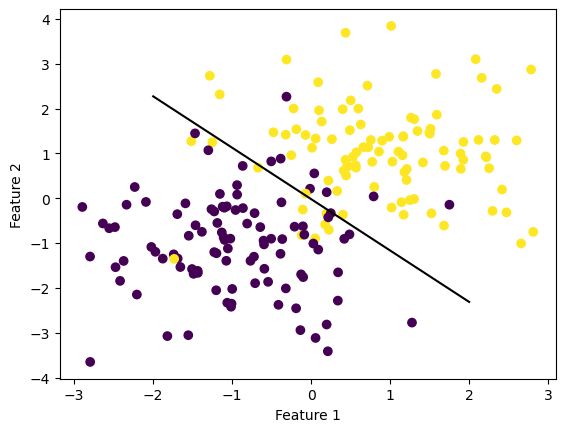

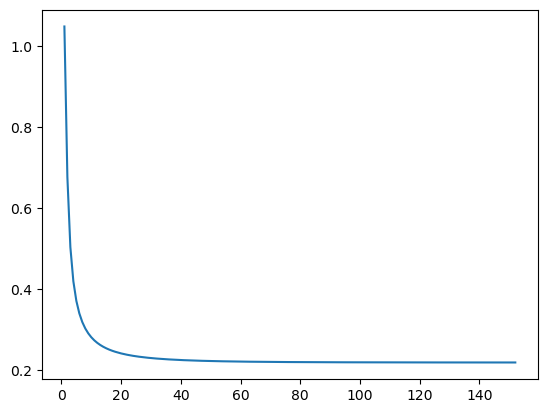

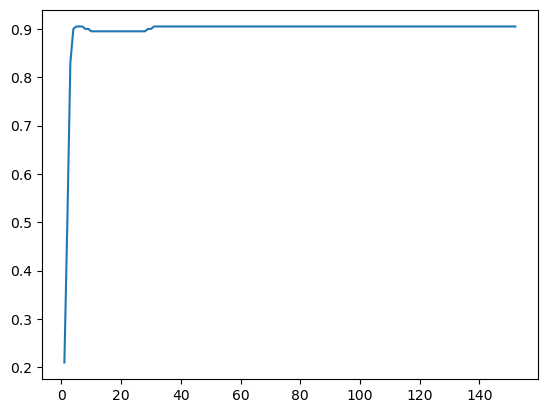

In [248]:
p_features = 10
X, y = make_blobs(n_samples = 200, n_features = p_features - 1, centers = [(-1, -1), (1, 1)])

LR = LogisticRegression()
LR.fit(X, y, alpha = 0.5, max_epochs=1000)

#Graph the data with a separator
fig = plt.scatter(X[:,0], X[:,1], c = y)
fig = draw_line(LR.w, -2, 2)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")
plt.show()

#Graph the gradient history 
num_steps = len(LR.loss_history)
loss_fig = plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "gradient")
plt.show()

#Graph the score history 
score_fig = plt.plot(np.arange(num_steps) + 1, LR.score_history, label = "accuracy")
plt.show()




We first see that the algorithm works pretty well. Even though the data is not linearly separable, unlike the perceptron, the gradient descent algorithm is able to accurately fit the weights to the data to find an accurate linear separator. We are also able to see how the accuracy improves until almost reaching 1. Now, lets try chaning alpha and see how it affects the gradien descent.  

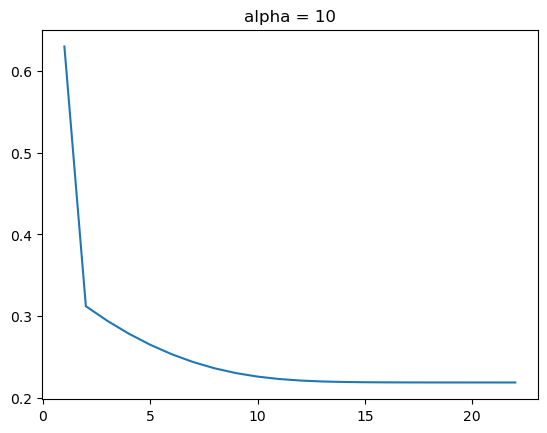

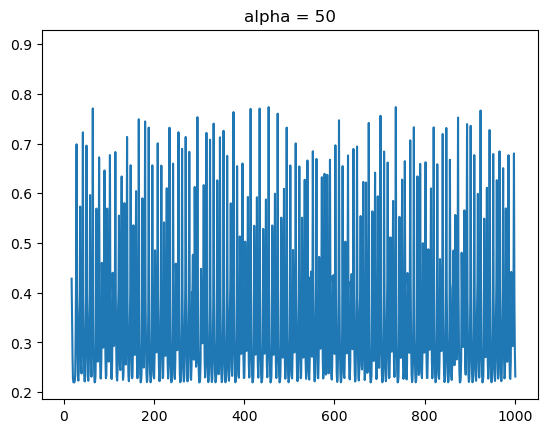

In [249]:
LR_a = LogisticRegression()
LR_a.fit(X, y, alpha = 10, max_epochs=1000)

num_steps = len(LR_a.loss_history)
loss_fig = plt.plot(np.arange(num_steps) + 1, LR_a.loss_history, label = "gradient")
plt.title("alpha = 10")
plt.show()

LR_A = LogisticRegression()
LR_A.fit(X, y, alpha = 50, max_epochs=1000)

num_steps = len(LR_A.loss_history)
loss_fig1 = plt.plot(np.arange(num_steps) + 1, LR_A.loss_history, label = "gradient")
plt.title("alpha = 50")
plt.show()


We can see in the first case that the gradient descent algorithm still converges but a little slower than with a small alpha. If we increase alpha to 50, however, the algorithm clearly does not converge. 

## Experiment 2

In this experiment we will explore how the size of the batches influences how quickly the stochastic gradient descent algorithm converges. 

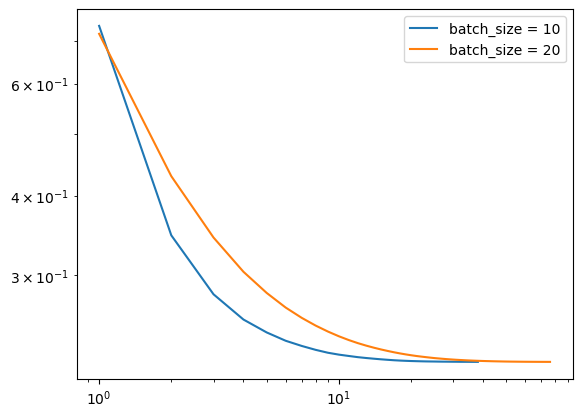

In [250]:
LR = LogisticRegression()
LR.fit_stochastic(X, y, 
    max_epochs = 1000, 
    batch_size = 10, 
    alpha = 0.1) 

num_steps = len(LR.loss_history)
plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "batch_size = 10")

LR = LogisticRegression()
LR.fit_stochastic(X, y, 
    max_epochs = 1000, 
    batch_size = 20, 
    alpha = 0.1) 

num_steps = len(LR.loss_history)
plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "batch_size = 20")

plt.loglog()

legend = plt.legend() 

It is possible to see how the size of the batch affets the convergence. In fact, it seems that a smaller size of the batch leads to a faster convergence. Intuitively, choosing a big size for the batch defeats the purpose of stochastic gradient descent, so it makes sense that a smaller size leads to a fast convergence. 

## Experiment 3

Now, we explore how the momentum method enhances the stochastic gradient descent. 

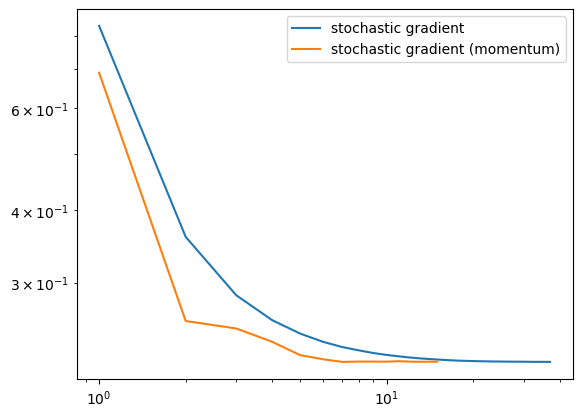

In [251]:
#Graph stochastic gradient descent
LR = LogisticRegression()
LR.fit_stochastic(X, y, 
    max_epochs = 100, 
    momentum = False, 
    batch_size = 10, 
    alpha = 0.1) 

num_steps = len(LR.loss_history)
plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "stochastic gradient")

#Graph stochastic gradient descent with momentum 
LR_m = LogisticRegression()
LR_m.fit_stochastic(X, y, 
    max_epochs = 100, 
    momentum = True, 
    batch_size = 10, 
    alpha = 0.1)

num_steps = len(LR_m.loss_history)
plt.plot(np.arange(num_steps) + 1, LR_m.loss_history, label = "stochastic gradient (momentum)")

plt.loglog()
legend = plt.legend() 

Even though there is some noice once it reaches convergence, the momentum method clearly speeds up convergence significantly. 

# Comparison between all the algorithms 

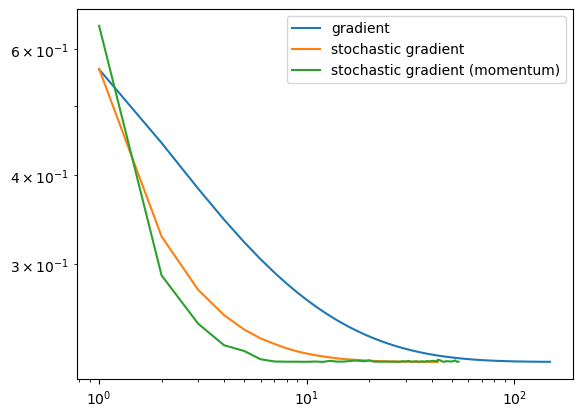

In [252]:
#Standard gradient descent
LR = LogisticRegression()
LR.fit(X, y, alpha = 0.5, max_epochs = 1000)

num_steps = len(LR.loss_history)
plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "gradient")

#Stochastic gradient descent
LR = LogisticRegression()
LR.fit_stochastic(X, y, 
    max_epochs = 1000, 
    momentum = False, 
    batch_size = 10, 
    alpha = 0.1)

num_steps = len(LR.loss_history)
plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "stochastic gradient")

#Stochastic gradient descent with momentum
LR = LogisticRegression()
LR.fit_stochastic(X, y, 
    max_epochs = 1000, 
    momentum = True, 
    batch_size = 10, 
    alpha = 0.1) 

num_steps = len(LR.loss_history)
plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "stochastic gradient (momentum)")

plt.loglog()

legend = plt.legend() 

In conclusion, we can see that the stochastic version of the gradient descent reaches convergence faster than the standard version. However, once it reaches convergence there seems to be some noise (unlike the standard gradient descent). 